# Learning rate 0.005

In [118]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as ds
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [95]:
# Device configuration
device = torch.device('cpu')

In [96]:
# Hyper parameters
num_epochs = 5
num_classes = 26
batch_size = 64
learning_rate = 0.005

In [97]:
# EMNIST dataset with train-validation split (85%-15%)
train_validation_dataset = ds.EMNIST(root='./data', split='letters',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

train_size = int(0.85 * len(train_validation_dataset))
val_size = len(train_validation_dataset) - train_size
train_dataset, val_dataset = random_split(train_validation_dataset, [train_size, val_size])

independent_test_dataset = ds.EMNIST(root='./data', split='letters',
                                     train=False,
                                     transform=transforms.ToTensor())

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=independent_test_dataset, batch_size=batch_size, shuffle=False)

In [98]:
# Convolutional neural network
class ConvNet(nn.Module):
    def __init__(self, num_classes=26):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.pool = nn.MaxPool2d(kernel_size=4, stride=2, padding=0)
        self.fc = nn.Linear(2*2*64, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.pool(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)


In [99]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [100]:
# Training and validation
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        labels = labels % num_classes

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    running_val_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            labels = labels % num_classes

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_f1 = f1_score(all_labels, all_preds, average='macro')

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Accuracy: {val_accuracy:.2f}%, '
          f'Validation Macro-F1: {val_f1:.4f}')

Epoch [1/5], Train Loss: 0.4314, Validation Loss: 0.2425, Train Accuracy: 86.44%, Validation Accuracy: 91.85%, Validation Macro-F1: 0.9187
Epoch [2/5], Train Loss: 0.2243, Validation Loss: 0.2251, Train Accuracy: 92.52%, Validation Accuracy: 92.29%, Validation Macro-F1: 0.9234
Epoch [3/5], Train Loss: 0.1980, Validation Loss: 0.2211, Train Accuracy: 93.34%, Validation Accuracy: 92.71%, Validation Macro-F1: 0.9270
Epoch [4/5], Train Loss: 0.1788, Validation Loss: 0.2227, Train Accuracy: 93.86%, Validation Accuracy: 92.32%, Validation Macro-F1: 0.9225
Epoch [5/5], Train Loss: 0.1648, Validation Loss: 0.2030, Train Accuracy: 94.24%, Validation Accuracy: 93.27%, Validation Macro-F1: 0.9326


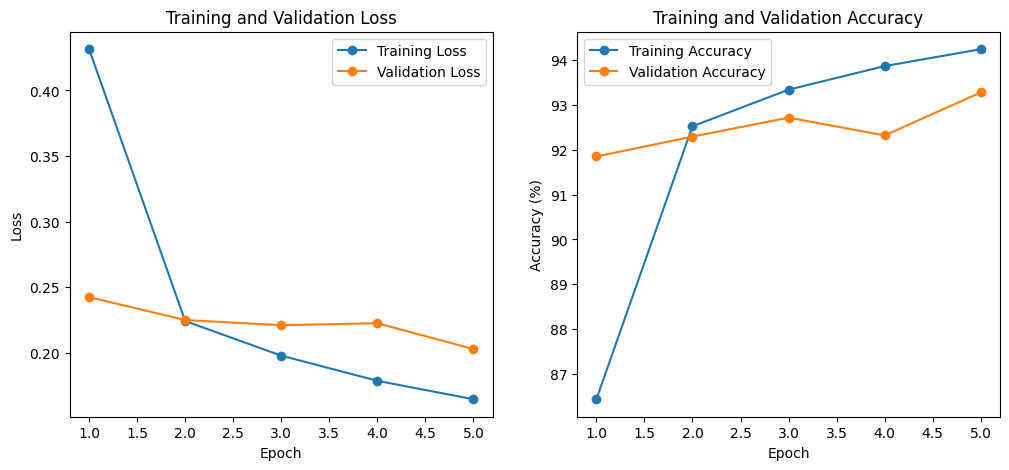

In [101]:
# Plotting the learning curves
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, '-o', label='Training Loss')
plt.plot(epochs, val_losses, '-o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, '-o', label='Training Accuracy')
plt.plot(epochs, val_accuracies, '-o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

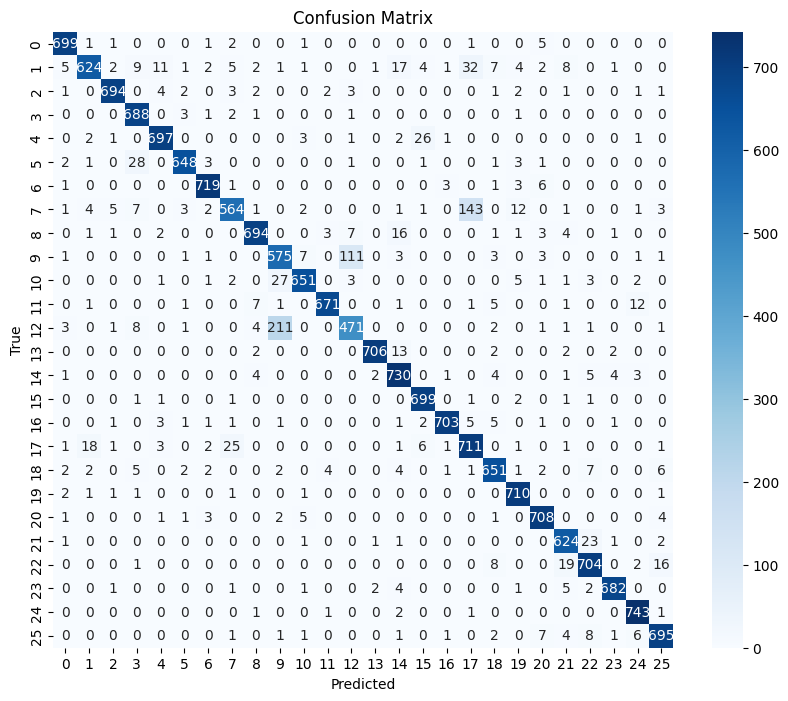

In [102]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Learning rate 0.001

In [119]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as ds
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [104]:
# Device configuration
device = torch.device('cpu')

In [105]:
# Hyper parameters
num_epochs = 5
num_classes = 26
batch_size = 64
learning_rate = 0.001

In [106]:
# EMNIST dataset with train-validation split (85%-15%)
train_validation_dataset = ds.EMNIST(root='./data', split='letters',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

train_size = int(0.85 * len(train_validation_dataset))
val_size = len(train_validation_dataset) - train_size
train_dataset, val_dataset = random_split(train_validation_dataset, [train_size, val_size])

independent_test_dataset = ds.EMNIST(root='./data', split='letters',
                                     train=False,
                                     transform=transforms.ToTensor())

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=independent_test_dataset, batch_size=batch_size, shuffle=False)

In [107]:
# Convolutional neural network
class ConvNet(nn.Module):
    def __init__(self, num_classes=26):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.pool = nn.MaxPool2d(kernel_size=4, stride=2, padding=0)
        self.fc = nn.Linear(2*2*64, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.pool(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)


In [108]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [109]:
# Training and validation
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        labels = labels % num_classes

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    running_val_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            labels = labels % num_classes

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_f1 = f1_score(all_labels, all_preds, average='macro')

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Accuracy: {val_accuracy:.2f}%, '
          f'Validation Macro-F1: {val_f1:.4f}')

Epoch [1/5], Train Loss: 0.4964, Validation Loss: 0.2628, Train Accuracy: 85.47%, Validation Accuracy: 91.40%, Validation Macro-F1: 0.9123
Epoch [2/5], Train Loss: 0.2307, Validation Loss: 0.2228, Train Accuracy: 92.33%, Validation Accuracy: 92.78%, Validation Macro-F1: 0.9274
Epoch [3/5], Train Loss: 0.1990, Validation Loss: 0.2072, Train Accuracy: 93.28%, Validation Accuracy: 93.24%, Validation Macro-F1: 0.9320
Epoch [4/5], Train Loss: 0.1769, Validation Loss: 0.1969, Train Accuracy: 93.90%, Validation Accuracy: 93.56%, Validation Macro-F1: 0.9351
Epoch [5/5], Train Loss: 0.1606, Validation Loss: 0.1964, Train Accuracy: 94.41%, Validation Accuracy: 93.50%, Validation Macro-F1: 0.9346


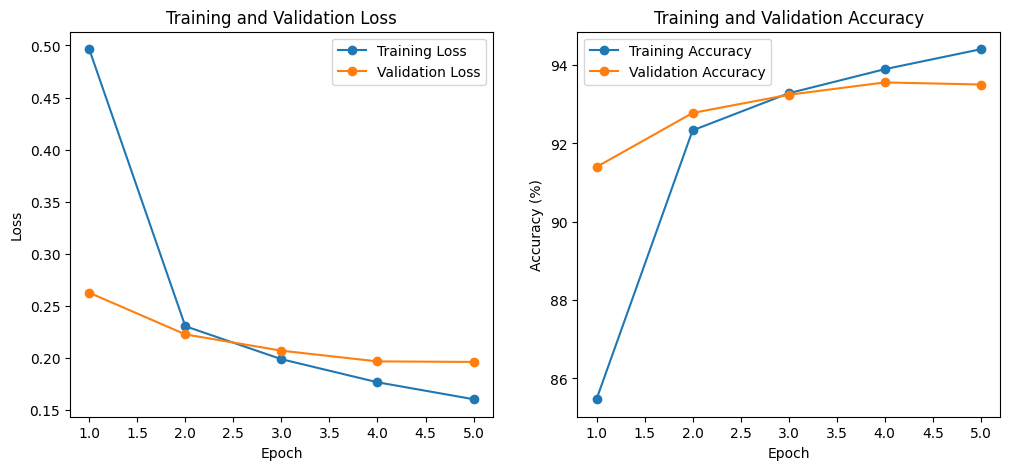

In [110]:
# Plotting the learning curves
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, '-o', label='Training Loss')
plt.plot(epochs, val_losses, '-o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, '-o', label='Training Accuracy')
plt.plot(epochs, val_accuracies, '-o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

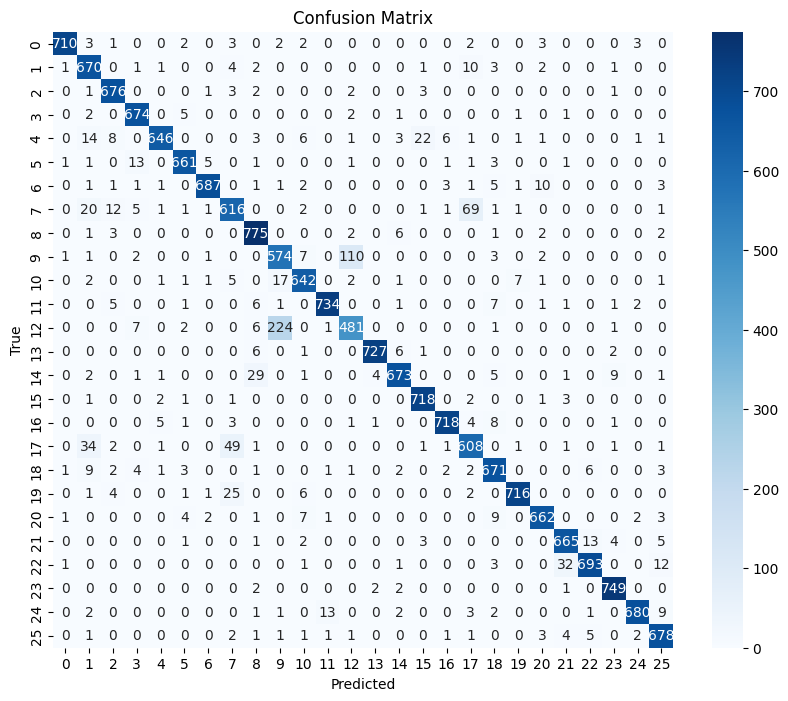

In [111]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [120]:
from sklearn.metrics import classification_report

In [121]:
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')


print("Classification Report:")
print(classification_report(all_labels, all_preds))

Test Accuracy: 89.72%
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.85      0.98      0.91       800
           2       0.95      0.98      0.97       800
           3       0.95      0.98      0.96       800
           4       0.97      0.92      0.95       800
           5       0.96      0.96      0.96       800
           6       0.99      0.94      0.97       800
           7       0.87      0.82      0.84       800
           8       0.91      0.96      0.94       800
           9       0.71      0.83      0.76       800
          10       0.95      0.95      0.95       800
          11       0.97      0.96      0.97       800
          12       0.80      0.68      0.74       800
          13       0.99      0.99      0.99       800
          14       0.97      0.91      0.94       800
          15       0.95      0.97      0.96       800
          16       0.99      0.98   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [126]:
independent_test_dataset[0][0].shape

torch.Size([1, 28, 28])

In [122]:
tst_img = torchvision.io.read_image("letter.jpg")
tst_img.shape

torch.Size([3, 4624, 3468])

In [143]:
tst_img_grey = transforms.Grayscale(num_output_channels=1)(tst_img)
tst_img_resized = transforms.Resize((28,28))(tst_img_grey)
tst_img_resized.shape

torch.Size([1, 28, 28])

In [145]:
tst_img_resized = tst_img_resized.float() / 255.0
tst_img_resized.shape

torch.Size([1, 28, 28])

In [146]:
model(tst_img_resized.reshape(1,1,28,28).to(device))

tensor([[ 0.1435, -2.3403, -2.2172,  2.2631, -2.4815, -2.3089,  1.7477, -2.0448,
         -1.0833,  3.9098,  3.1839, -2.2240,  4.1734, -5.2255, -1.4159, -3.3951,
         -0.3221, -2.8318,  1.6311, -0.0588,  0.8941, -2.7644, -0.2248, -4.9428,
         -3.2660,  0.1190]], grad_fn=<AddmmBackward0>)